Looking at Amazon's robots.txt file (or Twitter's, or Facebook's), you may be surprised to see them prohibit or severely restrict scraping.  Aren't there a lot of projects online using Twitter data?  And how dare they keep all that delicious, delicious information to themselves?  But before you start setting `'ROBOTSTXT_OBEY' = False`, read on!

Most of The Big Websites (Google, Facebook, Twitter, etc) have APIs that allow you to access their information programmatically without using webpages.  This is good for both you and the website.  With an API, you can ask the server to send you only the specific information you want, without having to retrieve, filter out, and discard the CSS, HTML, PHP, and other code from the website.  This minimizes demand on the server and speeds up your task.  

APIs typically include their own throttling to keep you from overloading the server, usually done by limiting the number of server requests per hour to a certain number.  

To access an API, you will usually need an API key or token that uniquely identifies you.  This lets the company or service providing the API keep an eye on your usage and track what you are doing.  Different API keys can also be associated with different levels of authorization and access, so they work as a data security measure.  Keys or tokens may also be set to expire after a certain amount of time or number of uses.

## Anatomy of an API

*Access*- You request a key.  Your program provides the key with each API call, and it determines what your program can do in the API.  
*Requests*- Your program requests the data you want with a call to the API.  The request will be made up of a method (type of query, using language defined by the API) and parameters (refine the query).  
*Response*- The data returned by the API, usually in a common format such as JSON that your program can parse.  

The specific syntax for each of these elements, and the format of the response, will vary from API to API.  In addition, APIs vary widely in their level of documentation and ease of use.  Before diving too deeply into an API-scraping project, do some judicious googling and if you see a lot of posts [like this one](https://mollyrocket.com/casey/stream_0029.html) consider going elsewhere.  Not all websites put their APIs front-and-center (did you know there are APIs for [NASA](https://api.nasa.gov/), [Marvel Comics](http://developer.marvel.com/), and [Star Wars](https://swapi.co/)?) so google will be your friend there as well.

## Basics of API Queries: Wikipedia's API

The process of using an API sounds a lot like scraping (make request, get response), but with an occasional added authorization layer.  Scrapy can handle authorization, so we can use it to access APIs too.

That said, the first API we'll pull from is [Wikipedia's](https://www.mediawiki.org/wiki/API:Main_page), which doesn't require an authorization key.  Aside from needing to master the API's language, you'll find that using scrapy with an API is very similar to using scrapy on a website.

We want to know what other entries on Wikipedia link to the [Monty Python](https://en.wikipedia.org/wiki/Monty_Python) page.  To do this, we can build a query using the [Wikipedia API Sandbox](https://en.wikipedia.org/wiki/Special:ApiSandbox).  Someone who is comfortable with the MediaWiki API syntax wouldn't need to use the sandbox, but for beginners it is very handy.  Note that API queries are nothing like SQL queries in syntax, despite their shared name.

The query we will use looks like this:
`https://en.wikipedia.org/w/api.php?action=query&format=xml&prop=linkshere&titles=Monty_Python&lhprop=title%7Credirect`

Let's break that down into it's components:

* `w/api.php`
    * Tells the server that we are using the API to pull info, rather than scraping the raw pages.  
    
* `action=query`   
    * We want information from the API (as opposed to changing information in the API)  
    
* `format=xml`  
    * Format the return in xml- then we will parse it with xpath  
    
* `prop=linkshere`  
    * We are interested in which pages link to our target page 
    
* `titles=Monty_Python`  
    * The target page is the Monty Python page.  Note that we used the exact name of the wikipedia page (Monty_Python).  
    
* `lhprop=title`  
    * From those links, we want the title of each page  
    
* `redirect`  
    * We also want to know if that link is a redirect  
    

The syntax of the MediaWiki API is based on php, thus the inclusion of `?` and `&` in the query.

For most of the query elements, we could have passed multiple arguments.  For example, we could request the URL as well as the title of the linking pages, or asked for all the pages that link to Monty_Python and to Monty_Python's_Flying_Circus.  

A query like this highlights why APIs are so handy.  Without an API, to find out the name of every page on Wikipedia that links to the Monty Python page we would have to scrape every single one of the 5,000,000+ articles in the English-language Wikipedia.  

If you haven't done so already, click on the query link above and see what it returns.



## Why use Scrapy for API calls

For some API calls, scrapy would be overkill.  If you know that your query can be answered in one response, then you don't need scrapy- you can use the `requests` library to make your API call and a library like `lxml` to parse the return.

The Wikipedia API, however, will only return ten items at a time in response to a query.  This sort of limitation is common to APIs to avoid overwhelming the server.  We can use scrapy to iterate over query results the same way that we iterated over the pages of the EverydaySexism website. 

Let's see the Wikipedia API and scrapy in action:



In [1]:
import scrapy
from scrapy.crawler import CrawlerProcess


class WikiSpider(scrapy.Spider):
    name = "WS"
    
    # Here is where we insert our API call.
    start_urls = [
        'https://en.wikipedia.org/w/api.php?action=query&format=xml&prop=linkshere&titles=Monty_Python&lhprop=title%7Credirect'
        ]

    # Identifying the information we want from the query response and extracting it using xpath.
    def parse(self, response):
        for item in response.xpath('//lh'):
            # The ns code identifies the type of page the link comes from.  '0' means it is a Wikipedia entry.
            # Other codes indicate links from 'Talk' pages, etc.  Since we are only interested in entries, we filter:
            if item.xpath('@ns').extract_first() == '0':
                yield {
                    'title': item.xpath('@title').extract_first() 
                    }
        # Getting the information needed to continue to the next ten entries.
        next_page = response.xpath('continue/@lhcontinue').extract_first()
        
        # Recursively calling the spider to process the next ten entries, if they exist.
        if next_page is not None:
            next_page = '{}&lhcontinue={}'.format(self.start_urls[0],next_page)
            yield scrapy.Request(next_page, callback=self.parse)
            
    
process = CrawlerProcess({
    'FEED_FORMAT': 'json',
    'FEED_URI': 'PythonLinks.json',
    # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
    'ROBOTSTXT_OBEY': False,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': False,
    # We use CLOSESPIDER_PAGECOUNT to limit our scraper to the first 100 links.    
    'CLOSESPIDER_PAGECOUNT' : 10
})
                                         

# Starting the crawler with our spider.
process.crawl(WikiSpider)
process.start()
print('First 100 links extracted!')

First 100 links extracted!


In [2]:
import pandas as pd

# Checking whether we got data 

Monty=pd.read_json('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/PythonLinks.json', orient='records')
print(Monty.shape)
print(Monty.tail())

(92, 1)
                        title
87               Hans Moleman
88              Ripping Yarns
89  List of British comedians
90         Wensleydale cheese
91              Art Garfunkel


## Wrap up

Our API call was successful.  While we examined 100 links, we only saved 92 (the others weren't links from entry pages).  

We've barely scraped (pun intended) the surface of what scrapy and APIs can do.  Scrapy has changed a lot in the years since its debut, so when googling make sure the answers you see are from 2015 at the latest-- otherwise you'll likely not be able to use the code.  

Back to the issue of authorization keys- often the key is simply included in the query string as an additional arguments.  In other cases, if you need your scraper to be able to enter a key or login information into a form, scrapy [has you covered](http://stackoverflow.com/questions/30102199/form-authentication-login-a-site-using-scrapy).  

There's a lot of fun to be had in scraping and APIs-- it's a way to feel like you're getting a lot of information with very little effort!  Beware, however.  You're not getting information at all.  Scraping gives you *data*, an undifferentiated mess of bytes with no compelling meaning on its own.  Think of that list of Wiki entries that link to Monty Python.  It's cool that we could get it, but what does it mean?  Your job as a data scientist is to convert *data* to *information*-- something people can use to make decisions or understand the world.  Modeling data to get information is hard but worthwhile work, and its those kinds of projects that will really build your portfolio as you go on the market.  

That said, scraping up some original data can provide the *foundation* for an interesting and original final project.

## Challenge

Do a little scraping or API-calling of your own.  Pick a new website and see what you can get out of it.  Expect that you'll run into bugs and blind alleys, and rely on your mentor to help you get through.  

Formally, your goal is to write a scraper that will:

1) Return specific pieces of information (rather than just downloading a whole page)  
2) Iterate over multiple pages/queries  
3) Save the data to your computer  

Once you have your data, compute some statistical summaries and/or visualizations that give you some new insights into your scraping topic of interest.  Write up a report from scraping code to summary and share it with your mentor.

In [6]:
# The following code was used to access the Twitter API. The code was left running on the terminal 
# for approximately an hour in order to gather the data
"""
#Import the necessary methods from tweepy library
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

#This is a basic listener that just prints received tweets to stdout.
class StdOutListener(StreamListener):
    def on_data(self, data):
        print(data)
        return True
    def on_error(self, status):
        print(status)

if __name__ == '__main__':

#This handles Twitter authetification and the connection to Twitter Streaming API
    l = StdOutListener()
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    stream = Stream(auth, l)

#This line filter Twitter Streams to capture data by the keywords: 'python', 'javascript', 'ruby'
    stream.filter(track=['python', 'javascript', 'ruby'])
"""
None

In [7]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import re

In [8]:
tweets_data = []
tweets_file = open('twitter_data.txt', "r")
for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue
print('After allowing our code to run for an hour or so, we gathered {} tweets.'.format(len(tweets_data)))

After allowing our code to run for an hour or so, we gathered 1385 tweets.


In [9]:
tweets = pd.DataFrame()
tweets['text'] = list(map(lambda tweet: tweet['text'], tweets_data))
tweets['lang'] = list(map(lambda tweet: tweet['lang'], tweets_data))
tweets['country'] = list(map(lambda tweet: tweet['place']['country'] if tweet['place'] != None else None, tweets_data))

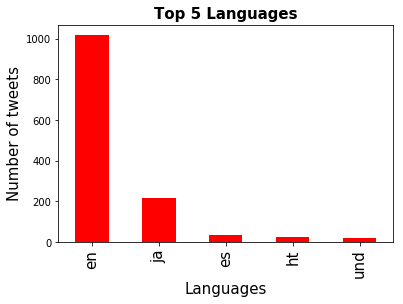

In [10]:
tweets_by_lang = tweets['lang'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 Languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red')

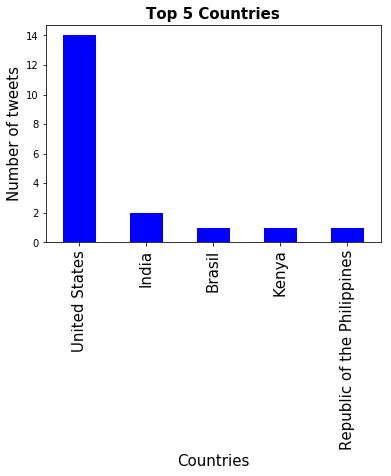

In [11]:
tweets_by_country = tweets['country'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 Countries', fontsize=15, fontweight='bold')
tweets_by_country[:5].plot(ax=ax, kind='bar', color='blue')

In [12]:
def word_in_text(word, text):
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)
    if match:
        return True
    return False

tweets['python'] = tweets['text'].apply(lambda tweet: word_in_text('python', tweet))
tweets['javascript'] = tweets['text'].apply(lambda tweet: word_in_text('javascript', tweet))
tweets['ruby'] = tweets['text'].apply(lambda tweet: word_in_text('ruby', tweet))

print("Tweets mentioning Python:\t", tweets['python'].value_counts()[True])
print("Tweets mentioning Javascript:\t", tweets['javascript'].value_counts()[True])
print("Tweets mentioning Ruby:\t\t", tweets['ruby'].value_counts()[True])

Tweets mentioning Python:	 325
Tweets mentioning Javascript:	 305
Tweets mentioning Ruby:		 497


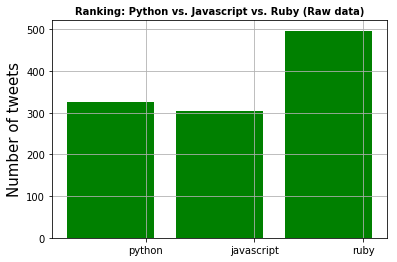

In [13]:
prg_langs = ['python', 'javascript', 'ruby']
tweets_by_prg_lang = [tweets['python'].value_counts()[True], 
                      tweets['javascript'].value_counts()[True], 
                      tweets['ruby'].value_counts()[True]]

x_pos = list(range(len(prg_langs)))
width = 0.8
fig, ax = plt.subplots()
plt.bar(x_pos, tweets_by_prg_lang, width, alpha=1, color='g')

# Setting axis labels and ticks
ax.set_ylabel('Number of tweets', fontsize=15)
ax.set_title('Ranking: Python vs. Javascript vs. Ruby (Raw data)', fontsize=10, fontweight='bold')
ax.set_xticks([p + 0.4 * width for p in x_pos])
ax.set_xticklabels(prg_langs)
plt.grid()

In [14]:
tweets['programming'] = tweets['text'].apply(lambda tweet: word_in_text('programming', tweet))
tweets['tutorial'] = tweets['text'].apply(lambda tweet: word_in_text('tutorial', tweet))
tweets['relevant'] = tweets['text'].apply(lambda tweet: word_in_text('programming', tweet) or word_in_text('tutorial', tweet))

print(tweets['programming'].value_counts()[True])
print(tweets['tutorial'].value_counts()[True])
print(tweets['relevant'].value_counts()[True])

59
17
76


In [15]:
print(tweets[tweets['relevant'] == True]['python'].value_counts()[True])
print(tweets[tweets['relevant'] == True]['javascript'].value_counts()[True])
print(tweets[tweets['relevant'] == True]['ruby'].value_counts()[True])

22
50
6


In [16]:
def extract_link(text):
    regex = r'https?://[^\s<>"]+|www\.[^\s<>"]+'
    match = re.search(regex, text)
    if match:
        return match.group()
    return ''

In [17]:
tweets['link'] = tweets['text'].apply(lambda tweet: extract_link(tweet))

In [18]:
tweets_relevant = tweets[tweets['relevant'] == True]
tweets_relevant_with_link = tweets_relevant[tweets_relevant['link'] != '']

In [19]:
print(tweets_relevant_with_link[tweets_relevant_with_link['python'] == True]['link'])
print(tweets_relevant_with_link[tweets_relevant_with_link['javascript'] == True]['link'])
print(tweets_relevant_with_link[tweets_relevant_with_link['ruby'] == True]['link'])

127      https://t.co/SSOeVXvcG5
160      https://t.co/c96kFUK5w0
223      https://t.co/c96kFUK5w0
264      https://t.co/heVWGFAua8
285      https://t.co/9MMw7MXELg
440     https://t.co/I7OILuASKN…
442      https://t.co/I7OILuASKN
443      https://t.co/I7OILuASKN
444      https://t.co/I7OILuASKN
450      https://t.co/I7OILuASKN
858      https://t.co/DXJm4V4s2g
914      https://t.co/telocxlomw
1035     https://t.co/aGRUpcgg4p
1133     https://t.co/38UAe8CVKw
1154     https://t.co/I7OILuASKN
Name: link, dtype: object
22      https://t.co/vg49Dh0UdG
37      https://t.co/vg49Dh0UdG
46      https://t.co/UayvKRUXOy
49      https://t.co/ssV7uNwM0m
99      https://t.co/UayvKRUXOy
165     https://t.co/UayvKRUXOy
179     https://t.co/ssV7uNwM0m
197     https://t.co/UayvKRUXOy
247     https://t.co/O4W7rBklB8
255           https://t.co/ZnE…
256     https://t.co/XS2UFPkrlC
296     https://t.co/XS2UFPkrlC
297     https://t.co/UayvKRUXOy
305           https://t.co/ZnE…
316     https://t.co/UayvKRUXOy